In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
#from sklearn.metrics import plot_confusion_matrix
from scipy import stats

# General Overview:
The focus of this notebook is to summarize information from the dataset and the performance of the models.  Filling in the parameters in the next cell and then running all cells will generate a series of figures and output them into the 'Figures' folder

In [95]:
root_path = Path(r'C:\Users\William\Google Drive (william.dl.cameron@gmail.com)\Insight Project')
project_path = root_path/'Output_Guys'
models_path = project_path/'Models'
images_path = project_path/'Images'
figures_path = project_path/'Figures'; figures_path.mkdir(exist_ok = True)
df = pd.read_csv(project_path/'final_with_cnn_and_tab_predictions.csv')

dep_var = 'engagement_factor_moving_avg'
df = df[~np.isnan(df[dep_var])]
df = df[df['is_valid'] == True]

sns.set_context("talk")
sns.set_style("white")

In [96]:
"""Functions.  Move to script"""

def preprocess_dataframe(df, dep_var, images_path):
    df = df[~np.isnan(df[dep_var])]
    return df

def append_predictions(df, preds, column_name = 'predictions'):
    df[column_name] = preds
    return df   


def get_stats(series):
    return series.mean(), series.std()

def normalize(series, mean, std):
    m, s = get_stats(series)
    new_series = np.add(np.multiply(np.subtract(series,m),(std/s)), mean)
    return new_series

def prepare_df(df, pred_col, target_col):
    df[norm_col] = normalize(df[pred_col], *get_stats(df[target_col]))
    
    return df

def make_accuracy_scatter(df, pred_col, target_col):
    sns.set_context("talk")
    sns.set_style("white")
    g = sns.lmplot(x = target_col, y = pred_col, data = df, aspect = 1, 
                   scatter_kws={"color":"darkred","alpha":0.3,"s":50})
    g.set_axis_labels('Target', 'Prediction')
    return g

def make_thresholded_confusion_matrix(df, pred_col, target_col, threshold, normalize_rows = True):
    
    
    target = df[target_col]
    pred = normalize(df[pred_col], *get_stats(target))
    #pred = df[pred_col]
    
    TP = pred[target<threshold]<threshold
    FP = pred[target>threshold]<threshold
    FN = pred[target<=threshold]>threshold
    TN = pred[target>=threshold]>=threshold

    TP_m, FP_m, FN_m, TN_m = TP.sum(), FP.sum(), FN.sum(), TN.sum()
    print('TP', TP_m, 'FP', FP_m, 'FN', FN_m, 'TN', TN_m)
    precision = TP_m/(TP_m+FP_m)
    recall = TP_m/(TP_m+FN_m)
    accuracy = (TP_m+TN_m)/(TP_m+TN_m+FP_m+FN_m)
    print(f'Precision: {precision}, Accuracy: {accuracy}, Recall: {recall}')

    classifications = [TP, FP, FN, TN]
    confusion_data = np.array([x.sum() for x in classifications]).reshape(-1, 2)
    if normalize_rows: confusion_data = [x/x.sum() for x in confusion_data]

    hm = sns.heatmap(confusion_data, annot=True, xticklabels = ['True', 'False'], yticklabels= ['True', 'False'])
    ax= hm.axes
    ax.set_ylim(2,0)
    ax.set_xlabel('Target')
    ax.set_ylabel('Prediction')
    return ax

def make_time_map(df):
    groups = df.groupby(['hour', 'day_name']).mean()[dep_var].unstack()
    groups = groups/groups.mean()
    groups.index = (groups.index-5)%24
    groups = groups.sort_index()
    groups.to_csv(figures_path/'time_data.csv')
    xticklabels = ['M','Tu','W','Th','F','Sa','Su']
    g = sns.heatmap(groups, cmap = 'coolwarm_r', xticklabels=xticklabels)
    ax= g.axes
    
    ax.set_xlabel('Day')
    ax.set_ylabel('Hour (EST)')
    #ax.set_yticks(ax.get_yticks()[::2])
    #print(ax.get_yticks())
    #plt.yticks(ax.get_yticks()[::2], ax.get_yticks()[::2], rotation='horizontal')
    ax.set_ylim(24,0)
    plt.yticks(rotation = 'horizontal')

    return ax


def make_violin_plot(df, param):
    plt.figure()
    max_value = 255
    df[f'{param}_bins'] = pd.cut(df[param], bins = 8) #qcut cuts into equal observations
    g = sns.violinplot(x=df[f'{param}_bins'], y=df[dep_var])
    g.set(xlabel = param.capitalize(), ylabel = 'Engagement', xticklabels = np.linspace(32,256,8, dtype='uint16'))
    save_seaborn_plot(g, figures_path/f'ViolinPlot-{param}.png')


def save_seaborn_plot(f, filepath):
    ax = f.get_figure()
    ax.tight_layout()
    ax.savefig(filepath, dpi = 600)

# Validation

In [101]:
DUD_THRESH = 0.7
project_path = project_path
target_col = dep_var  #dep_var
pred_col = 'cnn_prediction'
pred_col = 'tab_prediction'
#norm_col = 'normalized_preds'


#df = pd.read_csv(project_path/'final_with_cnn_and_tab_predictions.csv')
#df = prepare_df(df, pred_col, target_col)
get_stats(df[target_col]),get_stats(df[pred_col])#, get_stats(df[norm_col])

((1.0458790737601982, 0.42784899657290676),
 (1.0470035925022596, 0.24725750995287746))

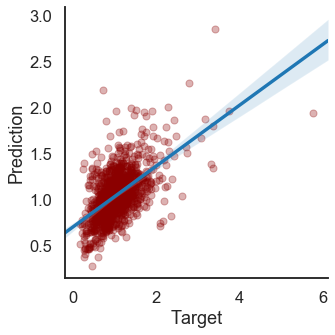

In [102]:
scatter_plt = make_accuracy_scatter(df, pred_col, target_col)
scatter_plt.savefig(figures_path/f'target_vs_prediction_{pred_col}.png', dpi = 600)

In [103]:
stats.linregress(df[target_col],df[pred_col])

LinregressResult(slope=0.3312387800497899, intercept=0.700567884030328, rvalue=0.5731683526916757, pvalue=6.671611095708616e-119, stderr=0.01288866679278193)

TP 72 FP 93 FN 64 TN 1123
Precision: 0.43636363636363634, Accuracy: 0.8838757396449705, Recall: 0.5294117647058824


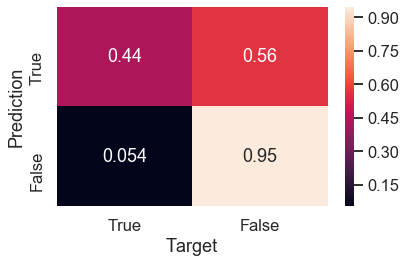

In [104]:
cf_matrix = make_thresholded_confusion_matrix(df, pred_col, target_col, 0.6, normalize_rows = True)
save_seaborn_plot(cf_matrix, figures_path/f'confusion_matrix_duds_{pred_col}.png')

TP 118 FP 129 FN 99 TN 1006
Precision: 0.4777327935222672, Accuracy: 0.8313609467455622, Recall: 0.543778801843318


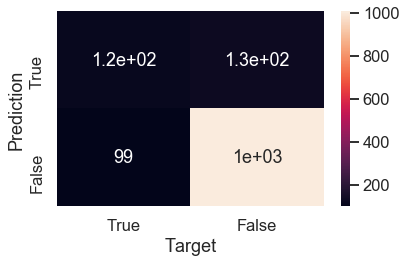

In [105]:
cf_matrix = make_thresholded_confusion_matrix(df,pred_col, target_col, 0.7, normalize_rows = False)
save_seaborn_plot(cf_matrix, figures_path/f'confusion_matrix_duds_{pred_col}_orig.png')

# Additional Metrics

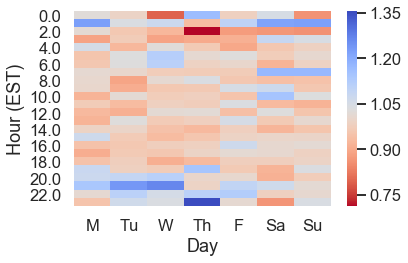

In [15]:
#Time dependency of likes
g = make_time_map(df)
save_seaborn_plot(g, figures_path/'time_dependency.png')

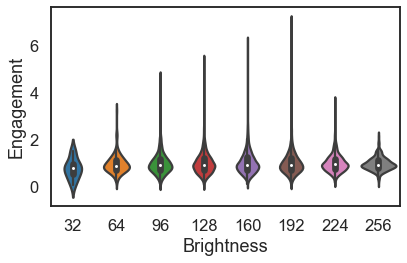

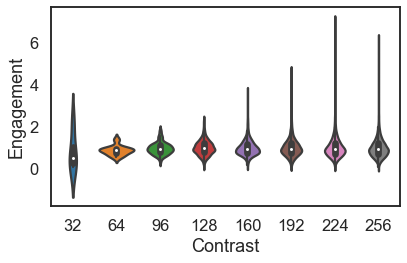

In [16]:
#Violin Plots
for param in ['brightness', 'contrast']:
    make_violin_plot(df, param)


In [17]:
#g = sns.violinplot(x=df[f'username'], y=df[dep_var])
#g.set(xlabel = param.capitalize(), ylabel = 'Engagement', xticklabels = np.linspace(32,256,8, dtype='uint16'))

TP 86 FP 376 FN 419 TN 1864
Precision: 0.18614718614718614, Accuracy: 0.7103825136612022, Recall: 0.1702970297029703


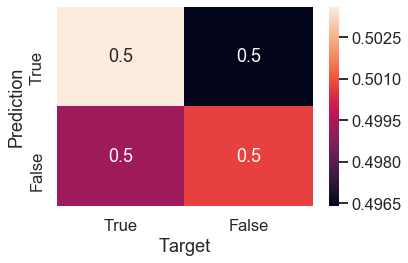

In [31]:
#Compare to Random Guess
df['random_guess'] = normalize(np.random.normal(size = len(df)), *get_stats(df[target_col]))
g = make_thresholded_confusion_matrix(df, pred_col, 'random_guess', threshold = 0.6)
save_seaborn_plot(g, figures_path/'random_guessing.png')

TP 357 FP 1592 FN 2125 TN 9763
Precision: 0.1831708568496665, Accuracy: 0.7313724073137241, Recall: 0.14383561643835616


KeyError: 'tab_only_prediction'

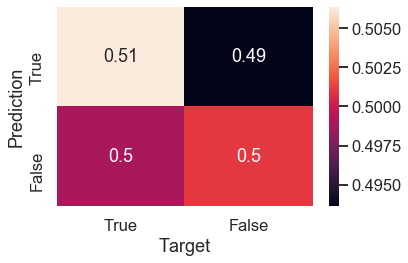

In [19]:
#Compare to Random Guess
df['random_guess'] = normalize(np.random.normal(size = len(df)), *get_stats(df[target_col]))
g = make_thresholded_confusion_matrix(df, pred_col, 'random_guess', threshold = 0.6)
save_seaborn_plot(g, figures_path/'random_guessing.png')




pred_columns = ['cnn_prediction', 'tab_only_prediction','tab_prediction',  'random_guess']
pred_names = ['CNN',  'Tab', 'Tab+CNN', 'RND']
r_values = []
for pred_type in pred_columns:
    regression = stats.linregress(df[target_col],df[pred_type])
    r_values.append(np.square(regression.rvalue))
plt.clf()
g = sns.barplot(x=pred_names, y=r_values)
g.set(xlabel='Model', ylabel = 'R-Squared')
save_seaborn_plot(g, figures_path/'R2_comparison.png')

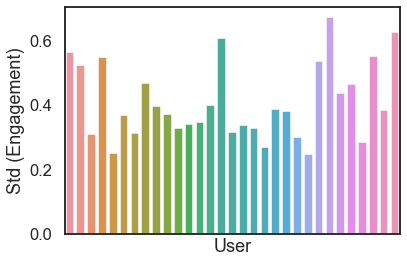

In [100]:
groups = df.groupby('username').std()
g = sns.barplot(x = groups.index, y = groups[dep_var])
g.set(xlabel = 'User', ylabel = 'Std (Engagement)', xticks = [])
save_seaborn_plot(g, figures_path/'User Engagement Variation')

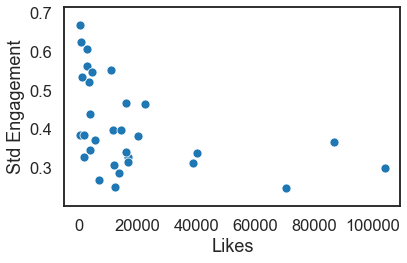

In [120]:
std_group = df.groupby('username').std()
avg_group = df.groupby('username').mean()
g = sns.scatterplot(x = avg_group['likes'], y = std_group[dep_var])
g.set(xlabel = 'Likes', ylabel = 'Std Engagement')
save_seaborn_plot(g, figures_path/'Variation in engagement vs Avg Likes.png')

[Text(0, 0.5, 'Engagement'), [], Text(0.5, 0, 'User')]

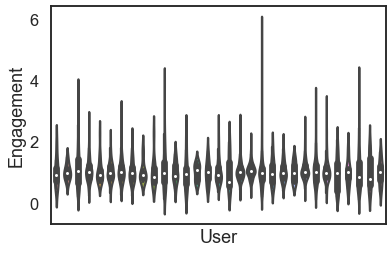

In [127]:
g = sns.violinplot(df['username'],df[dep_var])
g.set(ylabel = 'Engagement', xlabel = 'User', xticks = [])


In [8]:
std_group = df.groupby('username').std()

In [10]:
std_group['engagement_factor_moving_avg']

username
adamjwash                   0.562599
alejandro.quesada           0.521359
arielbenattar               0.307934
aurelien_muller_official    0.546847
charliemmatthews            0.249885
chico_lachowski             0.366718
christianhogue              0.310692
darrelljoness               0.466032
dusty__dusty                0.396381
igordenali                  0.370881
janis_danner                0.326554
jaygould_                   0.340186
jon_herrmann                0.346717
leviconely                  0.397510
lucasmontilla               0.605938
maxhamilton_                0.315759
michaelyerger               0.337068
nicholaskodua               0.328160
nicpalladino                0.267661
nikolamas                   0.385253
oliversvejse                0.381492
pietroboselli               0.299275
rafaelmiller                0.246220
realclintmauro              0.534896
ryanball92                  0.669665
ryanhoang                   0.437405
stefanpetrov                0

In [50]:
def make_histogram_plot(df, username, dep_var = 'engagement_factor_moving_avg', limit = 4):
    plt.clf()
    fig, ax = plt.subplots(1,1, figsize = (6,3))
    user_df = df[df['username']== username]
    g = sns.distplot(user_df[dep_var], bins = 100, hist=False, ax= ax)
    g.set(xlim=(0, 4), xlabel = 'Engagement', ylabel = 'Probability')
    return g

<Figure size 432x288 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

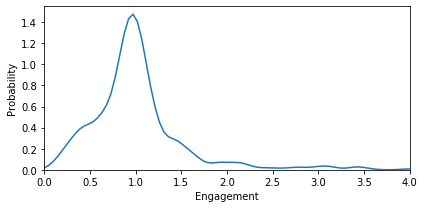

In [52]:
for username in ['zacharycharles_', 'rafaelmiller', 'adamjwash']:
    g = make_histogram_plot(df, username, dep_var)
    save_seaborn_plot(g, figures_path/f'STD - {username}.png')

[(0, 4)]

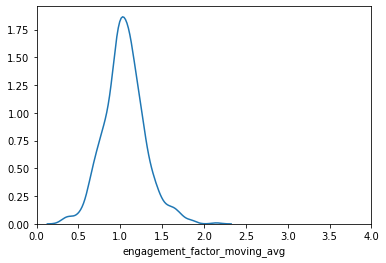

In [25]:
rm_user = df[df['username']=='rafaelmiller']
g = sns.distplot(rm_user['engagement_factor_moving_avg'], bins = 100, hist=False)
g.set(xlim=(0, 4))

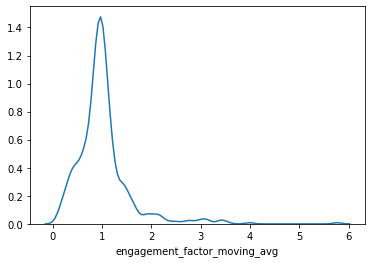

In [21]:
aw_user = df[df['username']=='adamjwash']
sns.distplot(aw_user['engagement_factor_moving_avg'], bins = 100, hist=False)

# Playground

In [ ]:
test_data = (ImageList.from_df(df, images_path, suffix = '.jpg', cols = 'filename')
             .filter_by_func(lambda x: (images_path/x).exists()))
learn = load_learner(models_path,'First Attempt.pkl', test = test_data)
preds = learn.get_preds(ds_type = DatasetType.Test)
df2 = append_predictions(filtered_df, preds[0])
df2.to_csv(project_path/'final_with_predictions.csv') 

In [ ]:
f = plt.figure(figsize=(6, 6))
gs = f.add_gridspec(2, 2)


ax_confusion_matrix = f.add_subplot(gs[0, 0])
sns.heatmap(cm2, annot=True, ax = ax_confusion_matrix)
ax_confusion_matrix.set_ylim(2, 0)

ax_pred_outcome = f.add_subplot(gs[0,1])
outt = sns.lmplot(x = target_col, y = pred_col, data = df)

outt.axes[0] = f.add_subplot(gs[0,1])

In [135]:
def get_image_from_url(url = None, output_dir = None):
    output_dir = Path('output') if output_dir is None else output_dir
    output_dir.mkdir(exist_ok=True)
    url = self.renavigation_check(url)
    #time.sleep(2)

    try:
        urllib.request.urlretrieve(download_link, output_dir/(url.split(r'/')[-2] + '.jpg'))
        image_path = output_dir/(url.split(r'/')[-2] + '.jpg')
    except:
        print('Couldnt print this one: ', url)
        return None
    return image

In [136]:
img_dir = Path(r"C:\Users\William\Google Drive (william.dl.cameron@gmail.com)\Insight Project\Insight-Github\webapp-new\flaskexample\single-images")

In [147]:
[str(x.relative_to(img_dir)) for x in img_dir.ls() if x.suffix == '.jpg']

['-4NkivnvZM.jpg',
 '-4TAfJwCNp.jpg',
 '05-EpyP7vG.jpg',
 '06BR4TqtPG.jpg',
 '06gvrAwCI6.jpg',
 '4NQmxMQCGZ.jpg',
 '4nYgvswCOJ.jpg',
 '4o20j4HvUm.jpg',
 '4P89OgHvYf.jpg',
 '4pWMoFHvV6.jpg',
 '4qTqkZwCAA.jpg',
 '4RgxYyv7oQ.jpg',
 '4SSXQdnvVl.jpg',
 '4sYQWrwCOo.jpg',
 '4ugMtfP7pp.jpg',
 '4uR2miHvSh.jpg',
 '4VcLi0wCGv.jpg',
 '4VYRZJnvV3.jpg',
 '4wgBaTnvZP.jpg',
 '4X-XKNwCBO.jpg',
 '4xBxKxv7vq.jpg',
 '4XWNmynvfv.jpg',
 '4yAGgCwCIn.jpg',
 '4z4pp1HvXf.jpg',
 '4Z5oodnvfk.jpg',
 '4Zo2ZPnvdg.jpg',
 '4ZoGAWv7vB.jpg',
 '5-uDI6Hvd0.jpg',
 '5AabwAQCMx.jpg',
 '5Aeli1wCFR.jpg',
 '5aNbvRv7gB.jpg',
 '5axgs2wCNd.jpg',
 '5BNf_2wCDx.jpg',
 '5C4_y2nvcf.jpg',
 '5cvXYDv7os.jpg',
 '5DKRz6QCMh.jpg',
 '5EGOfxQCIu.jpg',
 '5EMZfUwCP8.jpg',
 '5ewynCP7qT.jpg',
 '5f0MHnv7tF.jpg',
 '5ff6RLHvVI.jpg',
 '5FJsCgHveC.jpg',
 '5FuPJyKtLs.jpg',
 '5icTnSv7qx.jpg',
 '5IOHsknvYO.jpg',
 '5ISk7ZQCO5.jpg',
 '5JE2q9wCIC.jpg',
 '5j_j1iv7rn.jpg',
 '5lKqJDP7ou.jpg',
 '5lRWa9QCHi.jpg',
 '5mWf7VKtOh.jpg',
 '5nfI2GP7oJ.jpg',
 '5NoKtEnve9

In [154]:
img = open_image(r"C:\Users\William\Google Drive (william.dl.cameron@gmail.com)\Insight Project\Insight-Github\webapp-new\flaskexample\single_images\4RgxYyv7oQ.jpg")

fig, axs = plt.subplots(1,1, figsize = (4,4))
ax = axs
img.show(ax = axs)

TypeError: cannot unpack non-iterable Figure object